In [1]:
import cv2
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from tqdm import tqdm 
import h5py

import torch
import torch.nn as nn
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE  = torch.float32

In [2]:
# Functions

def asinh(image):
    alpha = 1
    bk = 0 
    return np.log10(alpha * (image - bk) + np.sqrt(alpha**2 * (image - bk)**2 + 1))

def min_max_norm(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def clip_0_1(image):
    return np.clip(image, 0, 1)

In [51]:
# First, we load and preprocess the data

data_path = "/Volumes/ES-HDD-Documents/Documents/CFHT_galaxies_with_streams/"
label_path = "/Volumes/ES-HDD-Documents/Documents/CFHT_galaxies_with_streams/streams_masks/"
data_list = np.loadtxt(data_path + "list_asinh.txt", dtype=str)
label_list = np.loadtxt(label_path + "/list_mask.txt", dtype=str)

In [56]:
# Open the .fits file
data   = np.zeros((len(data_list), 1, 3333, 3333))
labels = np.zeros((len(label_list), 1, 3333, 3333))

for i in tqdm(range(len(label_list)), leave=True):

    if i < len(data_list) and i!=68:
        with fits.open(data_path+data_list[i]) as hdul:
            data[i,0] = hdul[0].data
    if i == 68:
        with fits.open(data_path+data_list[i]) as hdul:
            data[i,0] = hdul[0].data[1666:3333+1666,1666:3333+1666]

    if i != 94 and i != 95:
        with fits.open(label_path+label_list[i]) as hdul:
            labels[i,0] = hdul[0].data
    else:
        with fits.open(label_path+label_list[i]) as hdul:
            labels[i,0] = hdul[0].data[1666:3333+1666,1666:3333+1666]

100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


In [58]:
processed_data = clip_0_1(asinh(data))

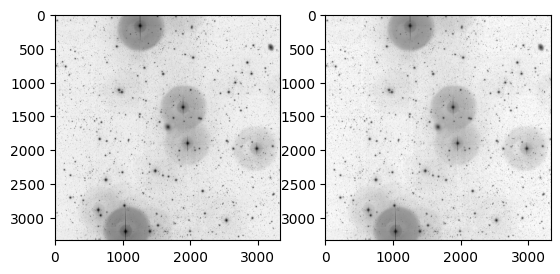

In [60]:
plt.subplot(1,2,1)
plt.imshow(processed_data[-1,0], cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(asinh(data[-1,0]),vmin=0,vmax=1, cmap='gray_r')

In [46]:
galaxy_names = np.loadtxt(data_path + "list_galaxy_names.txt", dtype=str)

# Remove newline characters and clean data
galaxy_names = [name.strip() for name in galaxy_names]
masks_name = [mask.strip() for mask in label_list]
data_name  = [d.strip() for d in data_list]

# Initialize a dictionary to store the results
mask_to_name = {}
data_to_name = {}

# Iterate through the mask list to extract galaxy names and find matches
for m in range(len(masks_name)):
    # Extracting galaxy name from mask string (assuming the format is consistent)
    mask_name = masks_name[m].split('_')[1]
    
    # Check if the extracted name is in the list of galaxy names
    if mask_name in galaxy_names:
        mask_to_name[m] = mask_name
    else:
        print(f"No match found for {masks_name[m]}")

    if m < len(data_list): 
        d_name = data_name[m].split('_')[0]
        
        # Check if the extracted name is in the list of galaxy names
        if d_name in galaxy_names:
            data_to_name[m] = d_name
        else:
            print(f"No match found for {data_to_name[m]}")


In [73]:
def find_keys_for_value(target_value, dictionary):
    # Gather all keys that correspond to the target_value
    keys = [key for key, value in dictionary.items() if value == target_value]
    return keys

In [67]:
mask_to_name_flip = {value: key for key, value in mask_to_name.items()}

In [83]:
processed_masks = np.zeros_like(processed_data)

for i in tqdm(range(len(data_to_name)), leave=True):
    name = data_to_name[i]
    keys_for_target_value = find_keys_for_value(name, mask_to_name)
    processed_masks[i] = labels[keys_for_target_value].sum(axis=0)


100%|██████████| 73/73 [00:05<00:00, 14.05it/s]


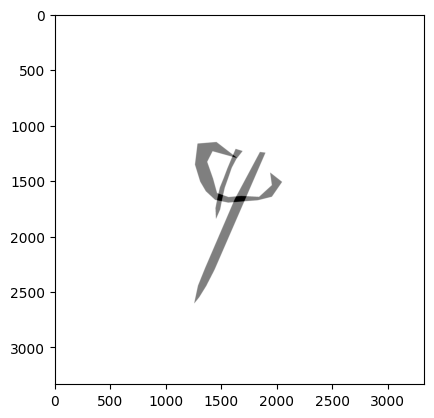

In [87]:
plt.imshow(processed_masks[2,0], cmap='gray_r')

In [89]:
# Set dimensions
with h5py.File(data_path+'galaxy_stream.h5', 'w') as f:
    f.create_dataset('images', data=processed_data, dtype='float32')
    f.create_dataset('masks', data=processed_masks, dtype='float32')


In [90]:
with h5py.File(data_path+'galaxy_stream.h5', 'r') as f:
    images = f['images'][:]
    masks  = f['masks'][:]


In [1]:
plt.imshow(processed_data, cmap='gray_r',origin='lower')#, norm=SymLogNorm(0.2))
plt.colorbar()
plt.savefig("test.png")

NameError: name 'plt' is not defined

In [64]:
# Load SAM Model for Fine Tunning

sam_checkpoint = "/Users/davidchemaly/Weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=DEVICE)

optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(),lr = 1e-4, weight_decay=0) 
loss_fn   = torch.nn.MSELoss()

In [65]:
# Test image

input_image = cv2.imread('stream_image.png')
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
input_image = torch.tensor(input_image, dtype=DTYPE, device=DEVICE).permute(2,0,1)[None]

In [40]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model.to(device)

sam_model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = sam_model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [19]:
# Just test
input = torch.zeros([3,32,32])

mask_generator = SamAutomaticMaskGenerator(sam_model)
masks = mask_generator.generate(input)
# sam_model.forward(input,False)

In [ ]:
# Load Data

data_path = "/Users/davidchemaly/Data/"
name_list = np.loadtxt()

In [13]:
sam_model = sam_model_registry['vit_b'](checkpoint='sam_vit_b_01ec64.pth')

In [17]:
model = Sam(ImageEncoderViT,MaskDecoder,PromptEncoder)
model.forward(test)
  

TypeError: forward() missing 1 required positional argument: 'multimask_output'